In [1]:
from sklearn.manifold.t_sne import TSNE
from umap import UMAP
import matplotlib.pyplot as plt

class VisualizationHandler():
    """
    Inspector for learned network. Conducts following inspections:

    """
    def __init__(self, Network, dataloaders, dataset_sizes, device='cuda:0', 
                 phase='test', save_path='./results/inspection/visualization'):
        self.Network = Network.to(device).eval()
        self.dataloaders = dataloaders
        self.dataset_sizes = dataset_sizes
        self.device = device
        self.save_path = save_path
        
        self.features = None
        self.labels = None
        self.correct = None
        self.confidence = None
        self.embedding = None
        
        
    def _forward(self, x):
        """
        Inference for a single batch. 
        
        [returns]   (Tensor) outputs : inference result tensor
                    (Tensor) features : features to be visualized
        """
        outputs, features = self.Network(x)
        return outputs, features
    
    
    def _prediction(self, outputs):
        """
        Prediction for a single batch inference result.
        
        [returns]   (Tensor) max_logits : maximum softmax output value tensor
                    (Tensor) pred : prediction result tensor
        """
        _, pred = torch.max(outputs, 1)
        return pred    
    
    
    def _attr_updater(self, tensor, mode='features'):
        if mode == 'features':
            if self.features is None:
                self.features = tensor

            else:
                self.features = torch.cat((self.features, tensor), dim=0)
        
        elif mode == 'labels':
            if self.labels is None:
                self.labels = tensor
            else:
                self.labels = torch.cat((self.labels, tensor), dim=0)
                
        elif mode == 'confidence':
            if self.confidence is None:
                self.confidence = tensor
            else:
                self.confidence = torch.cat((self.confidence, tensor), dim=0)
                
        elif mode == 'correct':
            if self.correct is None:
                self.correct = tensor
            else:
                self.correct = torch.cat((self.correct, tensor), dim=0)    
    
    def _inference(self, phase='test', set_confidence=True):
        """
        Inference for 
        
        [args]      (str) phase : use test or valid set 'valid' or 'test'
        
        [returns]   

        """
        correct, count = 0, 0
        size = self.dataset_sizes[phase]
                 
        with torch.no_grad():
            for inputs, labels in self.dataloaders[phase]:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                # Inference from Network
                outputs, features = self._forward(inputs)
                pred = self._prediction(outputs)

                self._attr_updater(features, 'features')
                self._attr_updater(labels, 'labels')

                # SR(softmax response)
                soft_out = F.softmax(outputs, dim=1)

                # maximum softmax response
                max_sr, _ = soft_out.max(dim=1) # maximum SR
                self._attr_updater(max_sr, 'confidence')
                
                correct_tensor = (pred == labels)
                self._attr_updater(correct_tensor, 'correct')

                correct += correct_tensor.sum().item()                    
        self.incorrect = self.correct != True
        self._to_numpy()
        total_acc = round(correct / size, 4)
        return total_acc

    
    def _embedder(self, phase='test', mode='umap', **kwargs):
        total_acc = self._inference(phase)
        print('%s phase accuracy is %0.4f %% \n' % (phase, total_acc))
        print('conducting feature embedding...')

        if mode == 'umap':
            reducer = UMAP(**kwargs)
        
        elif mode == 'tsne':
            reducer = TSNE(**kwargs)
        
            
        self.embedding = reducer.fit_transform(self.features)
        
        print('features are embedded as shape {}'.format(self.embedding.shape))

        
    def visualizer(self, phase='train', mode='umap', **kwargs):
        self._embedder(phase, mode, **kwargs)
        
        classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

        plt.figure(figsize=(16, 12))
        x, y = self.embedding[:,0], self.embedding[:,1]

        for i in range(len(classes)):
            y_i = self.labels == i
            plt.scatter(x[y_i], y[y_i], label=classes[i], alpha=1)
        plt.legend()
        
        """
        explanation

        [args]      (type) name: 

        [returns]   (type) name : 
        """
        """
        visualize learned representation.
        (args) type: select visualization type between 'umap' and 'tsne'
        """
        
    def _to_numpy(self):
        self.features = self.features.cpu().numpy()
        self.labels = self.labels.cpu().numpy()
        self.correct = self.correct.cpu().numpy()
        self.incorrect = self.incorrect.cpu().numpy()
        

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from models.adaptivecomp.utils import LogitCond, SL_Pair
from data_utils import cifar_10_setter, cifar_10_setter
from models.ResNet import resnet101, resnet18
from models.MobileNet import mobilenet_v2

dataloaders, dataset_sizes = cifar_10_setter(root='./data/cifar10')

net1 = resnet18(num_classes=10)
net1.load_state_dict(torch.load('./results/trained_models/ResNet18_ce_cifar10/trained_model.pth'))
net2 = resnet18(num_classes=10)
net2.load_state_dict(torch.load('./results/trained_models/ResNet18_sm_cifar10/trained_model.pth'))

#net1 = mobilenet_v2(num_classes=10)
#net1.load_state_dict(torch.load('./results/trained_models/MobileNet_ce_cosine500/trained_model.pth'))
#net2 = mobilenet_v2(num_classes=10)
#net2.load_state_dict(torch.load('./results/trained_models/MobileNet_sm_cosine500/trained_model.pth'))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


<All keys matched successfully>

train phase accuracy is 1.0000 % 

conducting feature embedding...


/home/gihun/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


features are embedded as shape (45000, 2)


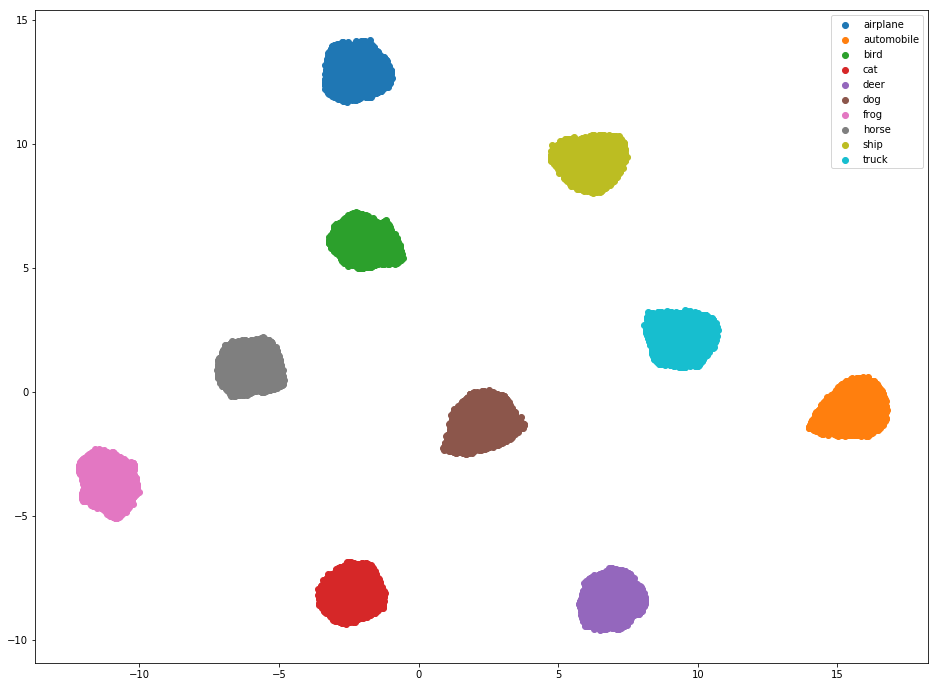

In [3]:
visualizer1 = VisualizationHandler(net1, dataloaders, dataset_sizes)
visualizer1.visualizer(mode='umap')

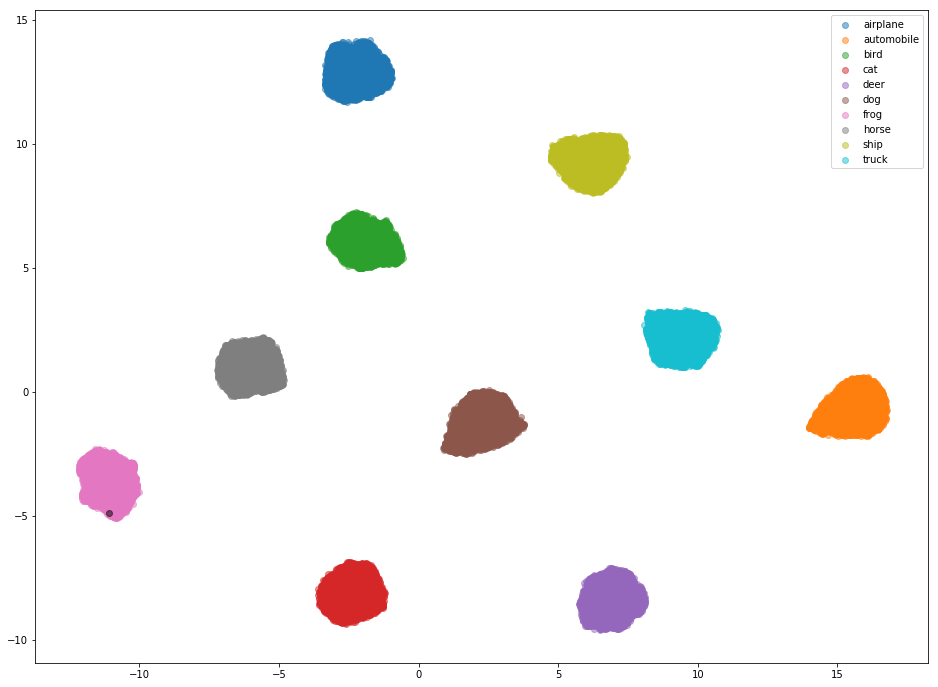

In [4]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

embedding = visualizer1.embedding
correct = visualizer1.correct
incorrect = visualizer1.incorrect
confidence = visualizer1.confidence
labels = visualizer1.labels

plt.figure(figsize=(16, 12))
x, y = embedding[:,0], embedding[:,1]

for i in range(len(classes)):
    y_i = labels == i
    plt.scatter(x[y_i], y[y_i], label=classes[i], alpha=0.5)
    
for i in range(len(classes)):
    y_i = labels[incorrect] == i
    plt.scatter(x[incorrect][y_i], y[incorrect][y_i], color='black', alpha=0.5)
plt.legend()

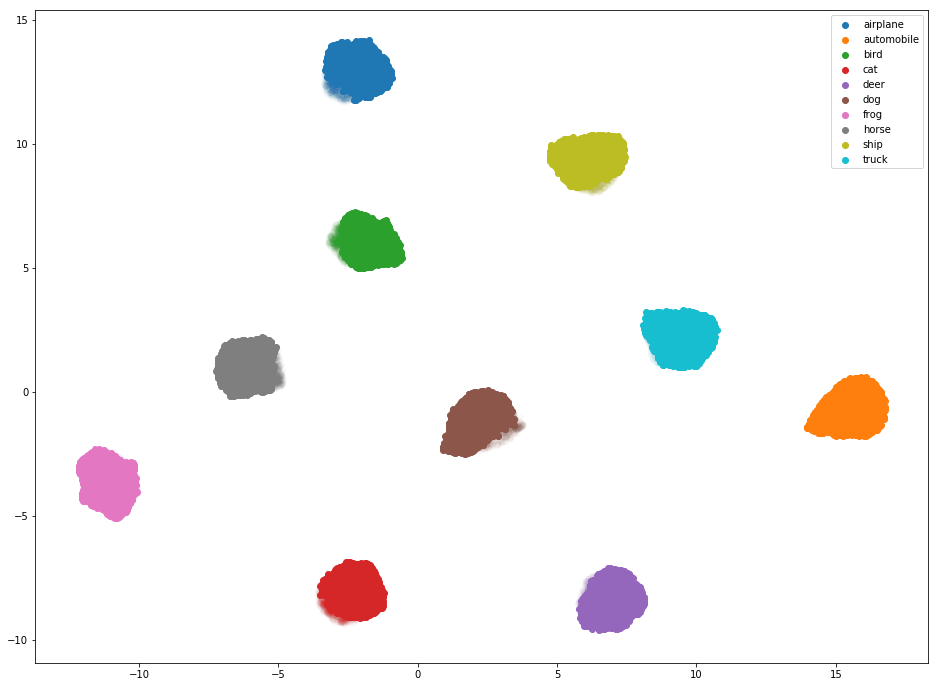

In [5]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

embedding = visualizer1.embedding
correct = visualizer1.correct
incorrect = visualizer1.incorrect
confidence = visualizer1.confidence
labels = visualizer1.labels

topk, _ = torch.topk(confidence, 8000)
certain = (confidence.cpu() > topk[-1]).numpy()
uncertain = (confidence.cpu() <= topk[-1]).numpy()

plt.figure(figsize=(16, 12))
x, y = embedding[:,0], embedding[:,1]

    
for i in range(len(classes)):
    y_i = labels[uncertain] == i
    plt.scatter(x[uncertain][y_i], y[uncertain][y_i], label=classes[i], alpha=1)

plt.legend()

    
for i in range(len(classes)):
    y_i = labels[certain] == i
    plt.scatter(x[certain][y_i], y[certain][y_i], label=classes[i], alpha=0.02)


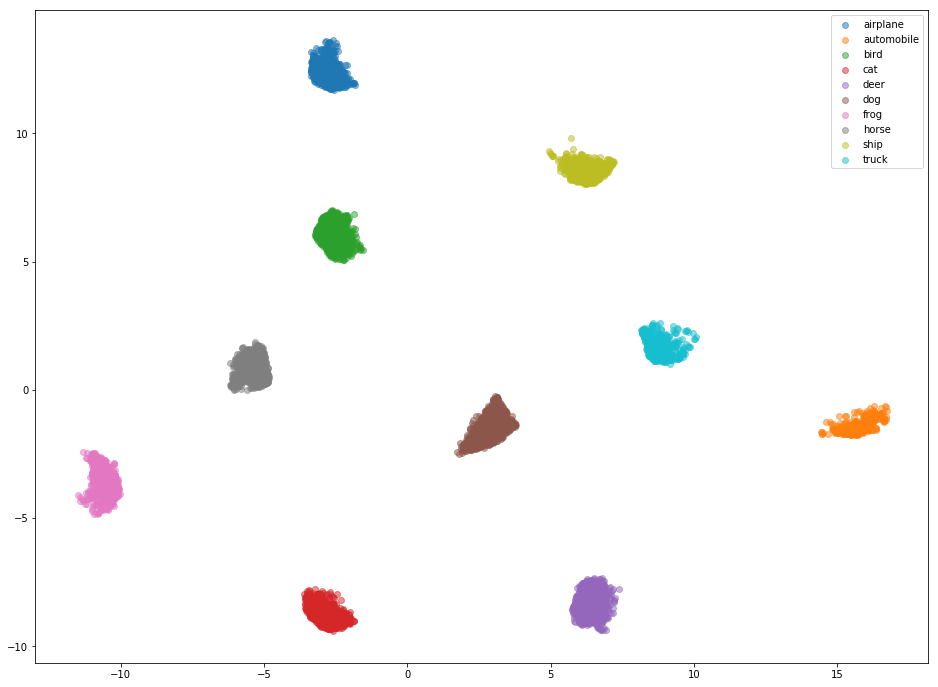

In [6]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

embedding = visualizer1.embedding
correct = visualizer1.correct
incorrect = visualizer1.incorrect
confidence = visualizer1.confidence
labels = visualizer1.labels

topk, _ = torch.topk(confidence, 8000)
certain = (confidence.cpu() > topk[-1]).numpy()

plt.figure(figsize=(16, 12))
x, y = embedding[:,0], embedding[:,1]

for i in range(len(classes)):
    y_i = labels[certain] == i
    plt.scatter(x[certain][y_i], y[certain][y_i], label=classes[i], alpha=0.5)

plt.legend()

train phase accuracy is 1.0000 % 

conducting feature embedding...


/home/gihun/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


features are embedded as shape (45000, 2)


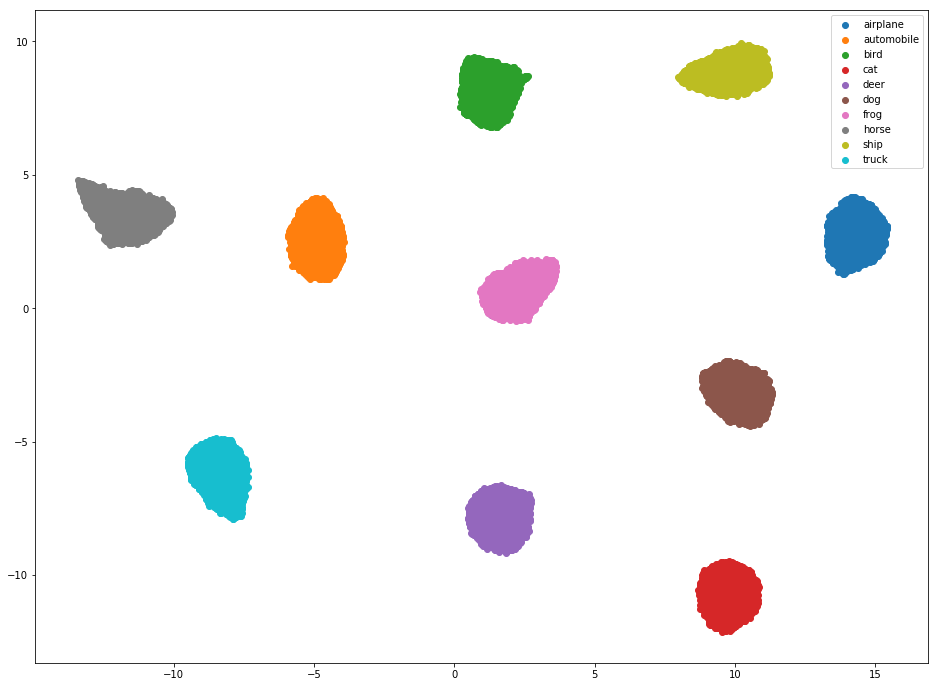

In [7]:
visualizer2 = VisualizationHandler(net2, dataloaders, dataset_sizes)
visualizer2.visualizer(mode='umap')

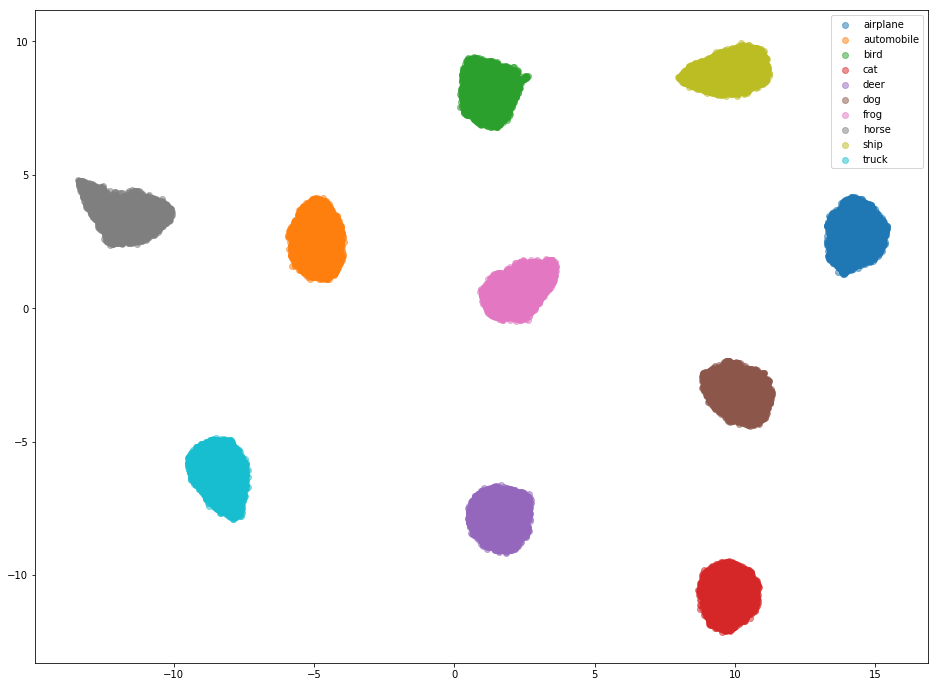

In [8]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

embedding = visualizer2.embedding
correct = visualizer2.correct
incorrect = visualizer2.incorrect
confidence = visualizer2.confidence
labels = visualizer2.labels

plt.figure(figsize=(16, 12))
x, y = embedding[:,0], embedding[:,1]

for i in range(len(classes)):
    y_i = labels == i
    plt.scatter(x[y_i], y[y_i], label=classes[i], alpha=0.5)
    
for i in range(len(classes)):
    y_i = labels[incorrect] == i
    plt.scatter(x[incorrect][y_i], y[incorrect][y_i], color='black', alpha=0.5)
plt.legend()

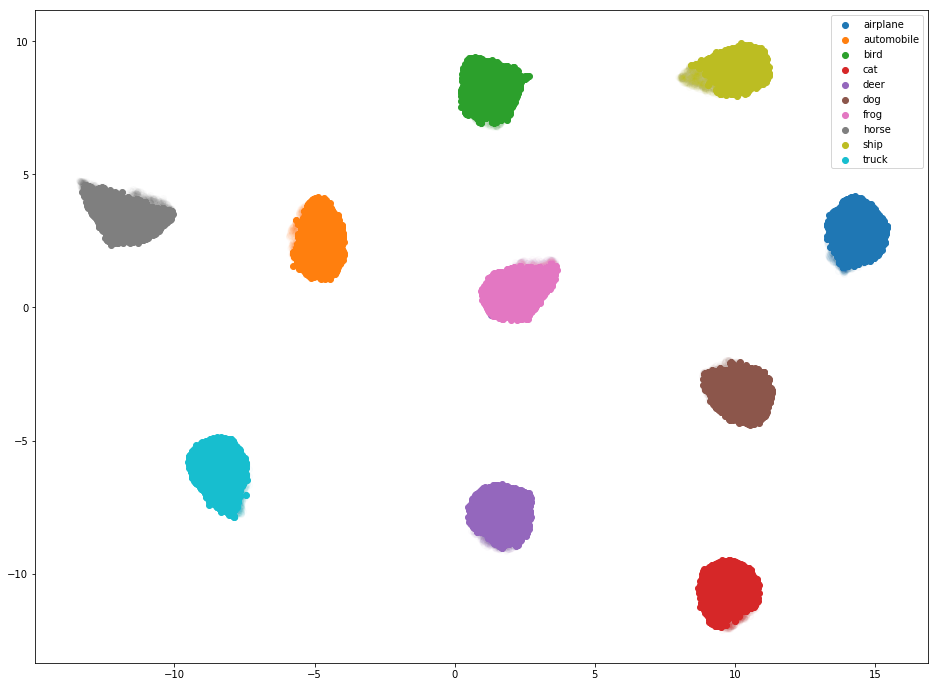

In [9]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

embedding = visualizer2.embedding
correct = visualizer2.correct
incorrect = visualizer2.incorrect
confidence = visualizer2.confidence
labels = visualizer2.labels

topk, _ = torch.topk(confidence, 8000)
certain = (confidence.cpu() > topk[-1]).numpy()
uncertain = (confidence.cpu() <= topk[-1]).numpy()

plt.figure(figsize=(16, 12))
x, y = embedding[:,0], embedding[:,1]

    
for i in range(len(classes)):
    y_i = labels[uncertain] == i
    plt.scatter(x[uncertain][y_i], y[uncertain][y_i], label=classes[i], alpha=1)

plt.legend()

    
for i in range(len(classes)):
    y_i = labels[certain] == i
    plt.scatter(x[certain][y_i], y[certain][y_i], label=classes[i], alpha=0.02)


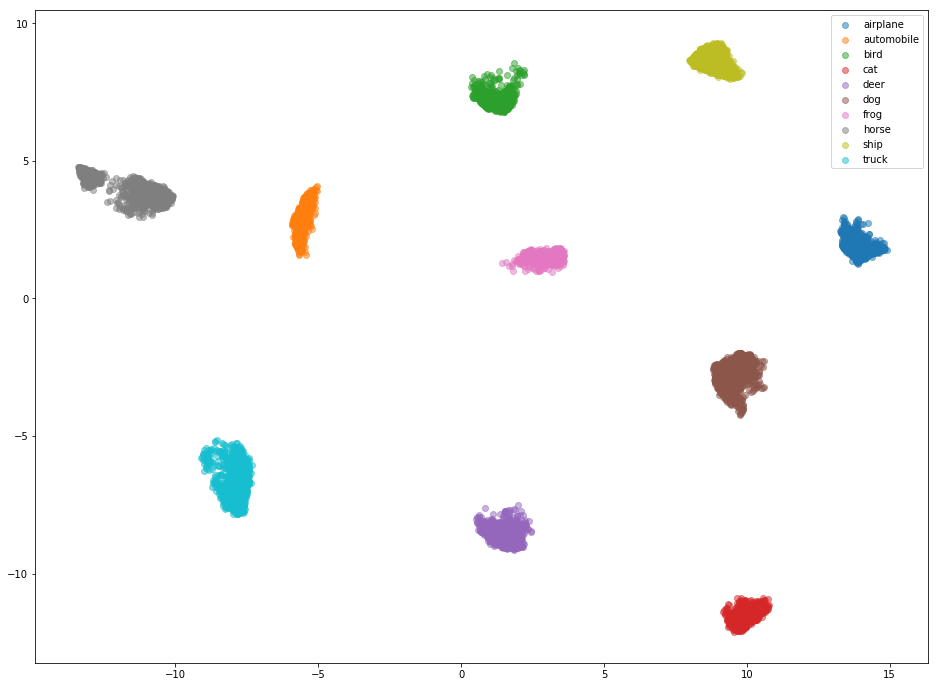

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

embedding = visualizer2.embedding
correct = visualizer2.correct
incorrect = visualizer2.incorrect
confidence = visualizer2.confidence
labels = visualizer2.labels

topk, _ = torch.topk(confidence, 8000)
certain = (confidence.cpu() > topk[-1]).numpy()

plt.figure(figsize=(16, 12))
x, y = embedding[:,0], embedding[:,1]

for i in range(len(classes)):
    y_i = labels[certain] == i
    plt.scatter(x[certain][y_i], y[certain][y_i], label=classes[i], alpha=0.5)

plt.legend()

----------

train phase accuracy is 1.0000 % 

conducting feature embedding...
features are embedded as shape (45000, 2)


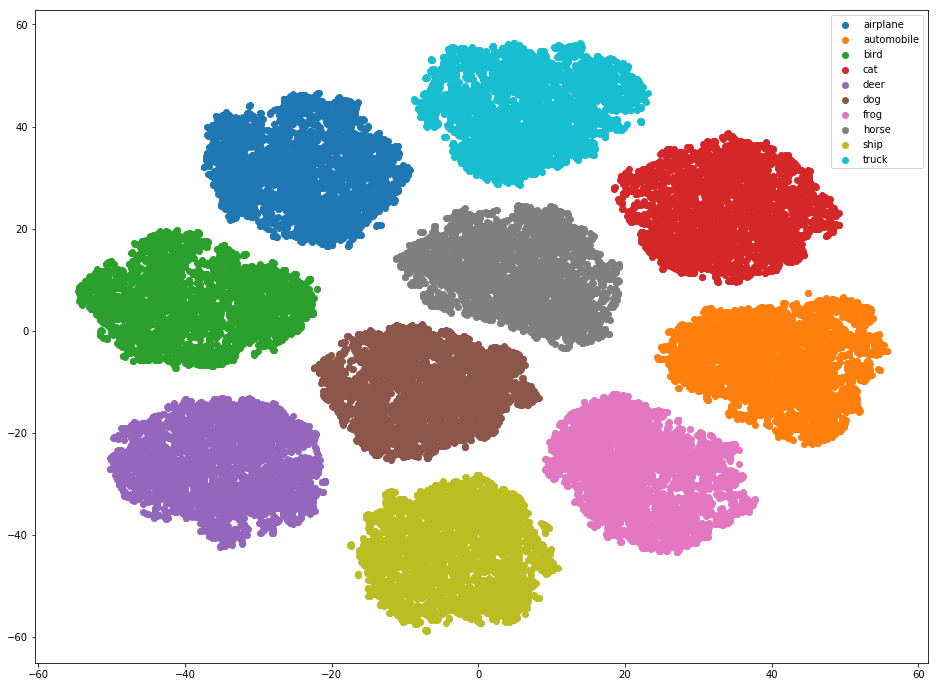

In [ ]:
visualizer1 = VisualizationHandler(net1, dataloaders, dataset_sizes)
visualizer1.visualizer(mode='tsne')

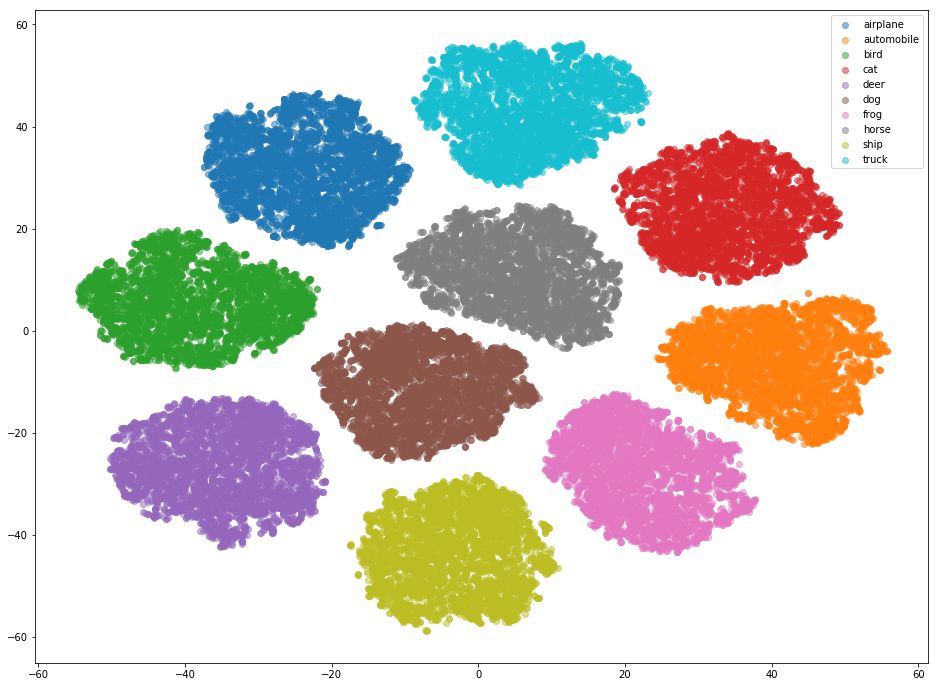

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

embedding = visualizer1.embedding
correct = visualizer1.correct
incorrect = visualizer1.incorrect
confidence = visualizer1.confidence
labels = visualizer1.labels

plt.figure(figsize=(16, 12))
x, y = embedding[:,0], embedding[:,1]

for i in range(len(classes)):
    y_i = labels == i
    plt.scatter(x[y_i], y[y_i], label=classes[i], alpha=0.5)
    
for i in range(len(classes)):
    y_i = labels[incorrect] == i
    plt.scatter(x[incorrect][y_i], y[incorrect][y_i], color='black', alpha=0.5)
plt.legend()

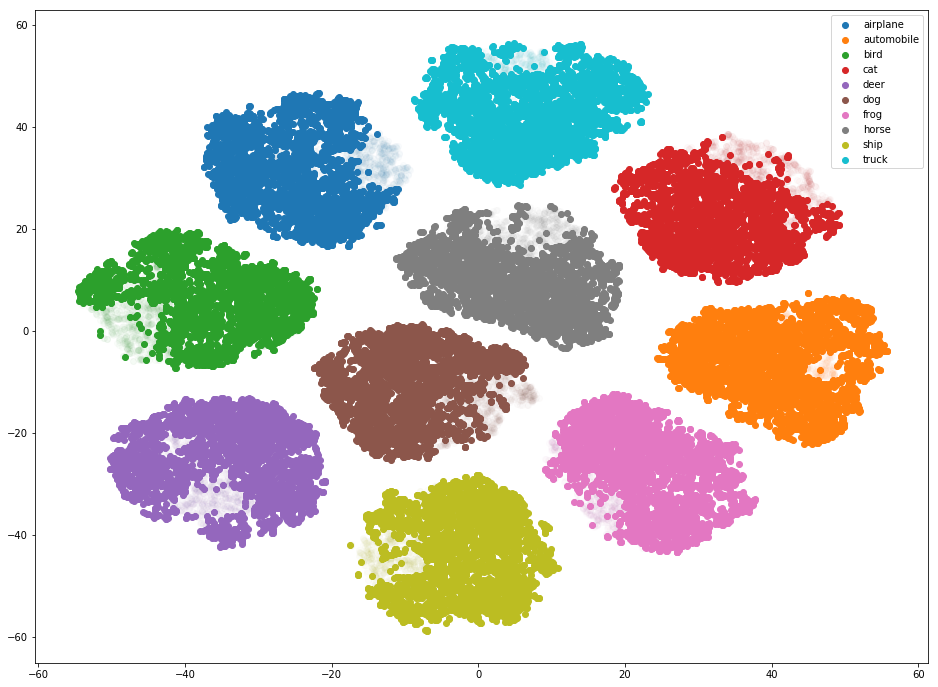

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

embedding = visualizer1.embedding
correct = visualizer1.correct
incorrect = visualizer1.incorrect
confidence = visualizer1.confidence
labels = visualizer1.labels

topk, _ = torch.topk(confidence, 8000)
certain = (confidence.cpu() > topk[-1]).numpy()
uncertain = (confidence.cpu() <= topk[-1]).numpy()

plt.figure(figsize=(16, 12))
x, y = embedding[:,0], embedding[:,1]

    
for i in range(len(classes)):
    y_i = labels[uncertain] == i
    plt.scatter(x[uncertain][y_i], y[uncertain][y_i], label=classes[i], alpha=1)

plt.legend()

    
for i in range(len(classes)):
    y_i = labels[certain] == i
    plt.scatter(x[certain][y_i], y[certain][y_i], label=classes[i], alpha=0.02)


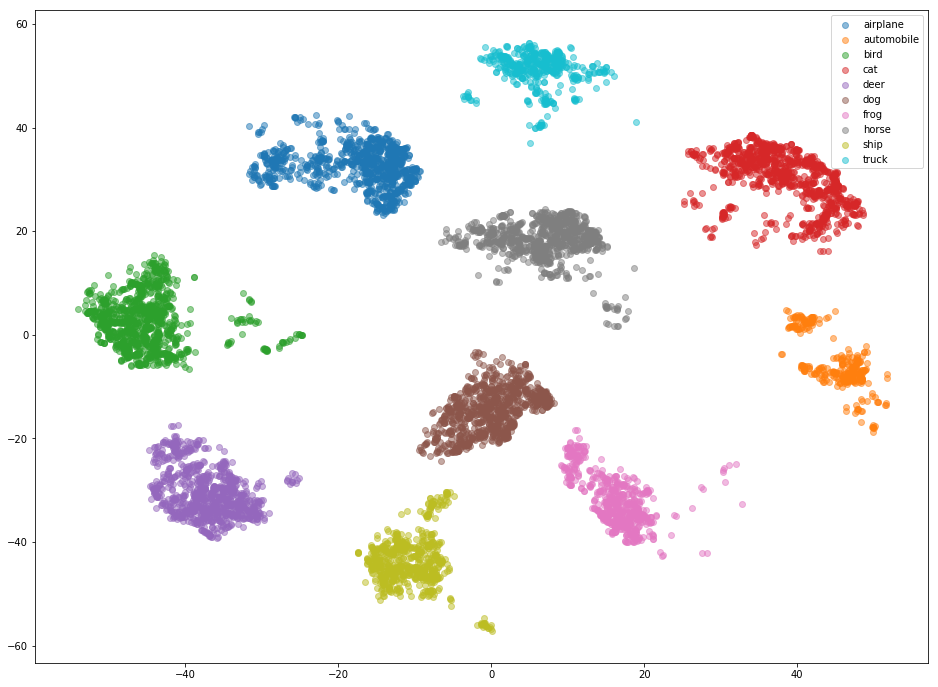

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

embedding = visualizer1.embedding
correct = visualizer1.correct
incorrect = visualizer1.incorrect
confidence = visualizer1.confidence
labels = visualizer1.labels

topk, _ = torch.topk(confidence, 8000)
certain = (confidence.cpu() > topk[-1]).numpy()

plt.figure(figsize=(16, 12))
x, y = embedding[:,0], embedding[:,1]

for i in range(len(classes)):
    y_i = labels[certain] == i
    plt.scatter(x[certain][y_i], y[certain][y_i], label=classes[i], alpha=0.5)

plt.legend()

In [ ]:
visualizer2 = VisualizationHandler(net2, dataloaders, dataset_sizes)
visualizer2.visualizer(mode='tsne')

train phase accuracy is 1.0000 % 

conducting feature embedding...


In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

embedding = visualizer2.embedding
correct = visualizer2.correct
incorrect = visualizer2.incorrect
confidence = visualizer2.confidence
labels = visualizer2.labels

plt.figure(figsize=(16, 12))
x, y = embedding[:,0], embedding[:,1]

for i in range(len(classes)):
    y_i = labels == i
    plt.scatter(x[y_i], y[y_i], label=classes[i], alpha=0.5)
    
for i in range(len(classes)):
    y_i = labels[incorrect] == i
    plt.scatter(x[incorrect][y_i], y[incorrect][y_i], color='black', alpha=0.5)
plt.legend()

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

embedding = visualizer2.embedding
correct = visualizer2.correct
incorrect = visualizer2.incorrect
confidence = visualizer2.confidence
labels = visualizer2.labels

topk, _ = torch.topk(confidence, 8000)
certain = (confidence.cpu() > topk[-1]).numpy()
uncertain = (confidence.cpu() <= topk[-1]).numpy()

plt.figure(figsize=(16, 12))
x, y = embedding[:,0], embedding[:,1]

    
for i in range(len(classes)):
    y_i = labels[uncertain] == i
    plt.scatter(x[uncertain][y_i], y[uncertain][y_i], label=classes[i], alpha=1)

plt.legend()

    
for i in range(len(classes)):
    y_i = labels[certain] == i
    plt.scatter(x[certain][y_i], y[certain][y_i], label=classes[i], alpha=0.02)


In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

embedding = visualizer2.embedding
correct = visualizer2.correct
incorrect = visualizer2.incorrect
confidence = visualizer2.confidence
labels = visualizer2.labels

topk, _ = torch.topk(confidence, 8000)
certain = (confidence.cpu() > topk[-1]).numpy()

plt.figure(figsize=(16, 12))
x, y = embedding[:,0], embedding[:,1]

for i in range(len(classes)):
    y_i = labels[certain] == i
    plt.scatter(x[certain][y_i], y[certain][y_i], label=classes[i], alpha=0.5)

plt.legend()